# Benchmark of TopOMetry on Toy and real-world datasets

In [2]:
import numpy as np
import pandas as pd
import topo as tp
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
import time
import warnings
from itertools import cycle, islice

%matplotlib inline

## First we generate some toy data

In [3]:
np.random.seed(0)
n_samples = 10000
from sklearn.utils import check_random_state

##########
# Gaussian
##########

gaussian = datasets.make_gaussian_quantiles(n_samples=n_samples, n_classes=1)




##########
# Circles and moons with added noise
##########

noisy_circles = datasets.make_circles(n_samples=n_samples, 
                        factor=.5,
                        noise=.05)

noisy_moons = datasets.make_moons(n_samples=n_samples, 
                                  noise=.05)

##########
# Now a uniform square and a uniform grid
##########
x = np.linspace(0, 1, int(np.sqrt(n_samples)))
xx, yy = np.meshgrid(x, x)
grid = np.hstack(
    [
        xx.ravel().reshape(-1, 1),
        yy.ravel().reshape(-1, 1),
    ]
)

no_structure = np.random.rand(n_samples, 2), None  #uniform data on a square


##########
# Blobs - uniform, anisotropic and with varying variances
##########
blobs = datasets.make_blobs(n_samples=n_samples, random_state=42)

# anisotropic
random_state = 42
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
blobs_aniso = (X_aniso, y)

# varying variances
blobs_varvar = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# S curve with some noise
s_curve  = datasets.make_s_curve(n_samples=n_samples, noise=.05)


# swiss roll with some noise
swiss_roll = datasets.make_swiss_roll(n_samples=n_samples, noise=.05) 

In [4]:
toy_datasets = {
     'noisy_circles':noisy_circles,
     'noisy_moons':noisy_moons,
     'blobs_uniform':blobs,
     'blobs_varying_variance':blobs_varvar,
     'blobs_anisotropic':blobs_aniso,
     's_curve':s_curve,
     'swiss_roll':swiss_roll,
     'uniform_square':no_structure,
     'gaussian':gaussian}

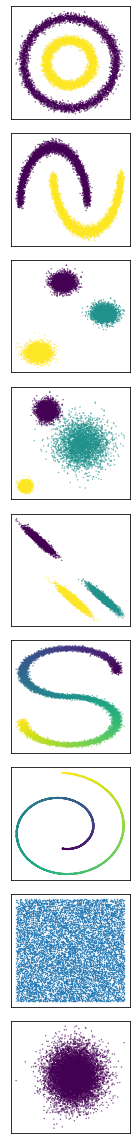

In [4]:
fig, axes = plt.subplots(9,1,figsize=(2,16))
fig.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)
for i, dataset_name in enumerate(toy_datasets):
    ax = axes[i]
    data, color = toy_datasets[dataset_name]
    
    # normalize dataset for easier parameter selection
    data = preprocessing.StandardScaler().fit_transform(data)
    if (dataset_name == 's_curve') or (dataset_name == 'swiss_roll'):
        ax.scatter(data[:,0], data[:,2] , c=color, s=0.1)
    else:
        ax.scatter(data[:,0], data[:,1] , c=color, s=0.1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

fig.tight_layout()

## Define DR methods to be tested

In [5]:
# First, general models (including some of those used in TopOMetry)

from sklearn import decomposition, manifold


# PCA
def PCA(data, n_pcs=2):
    return decomposition.PCA(n_components=n_pcs).fit_transform(data)

# kernel PCA
def KernelPCA(data, n_pcs=2, kernel='rbf'):
    return decomposition.KernelPCA(n_components=n_pcs, kernel=kernel).fit_transform(data)

# SVD
def TruncatedSVD(data, n_pcs=2):
    return decomposition.TruncatedSVD(n_components=n_pcs, algorithm='arpack').fit_transform(data)

# NMF
def NMF(data, n_components=2):
    return decomposition.NMF(n_components=n_components).fit_transform(data)

# This is an adaptive length scaling implementation

def DM(data, t=100, n_neighbors=5, metric='euclidean', n_components=3, n_jobs=-1, alpha=1, tol=0):
    from scipy.sparse import csr_matrix, linalg, find
    # kernel construction
    N = np.shape(data)[0]
    knn = tp.ann.kNN(data, n_neighbors=n_neighbors,
                            metric=metric,
                            n_jobs=n_jobs)
    median_k = np.floor(n_neighbors / 2).astype(int)
    adap_sd = np.zeros(N)
    for i in np.arange(len(adap_sd)):
        adap_sd[i] = np.sort(knn.data[knn.indptr[i]: knn.indptr[i + 1]])[
            median_k - 1
            ]
    x, y, dists = find(knn)
    dists = dists / (adap_sd[x] + 1e-10)
    K = csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])
    K = (K + K.T) / 2
    
    # Update kernel, diffusion through Markov chain (anisotropic diffusion)
    D = np.ravel(K.sum(axis=1))
    if alpha > 0:
        # L_alpha
        D[D != 0] = D[D != 0] ** (-alpha)
        Dmat = csr_matrix((D, (range(N), range(N))), shape=[N, N])
        K = Dmat.dot(K).dot(Dmat)
        D = np.ravel(K.sum(axis=1))
    D[D != 0] = 1 / D[D != 0]
    # transitions probabilities
    T = csr_matrix((D, (range(N), range(N))), shape=[N, N]).dot(K)
    D, V = linalg.eigs(T, n_components+1, tol=tol, maxiter=N)
    D = np.real(D)
    V = np.real(V)
    inds = np.argsort(D)[::-1]
    D = D[inds]
    V = V[:, inds]
    for i in range(V.shape[1]):
        V[:, i] = V[:, i] / np.linalg.norm(V[:, i])
    V1 = V[:, 0][:, None]
    V = V/V1
    V, D = V[:, 1:], D[1:]
    D = np.power(D, t)
    embedding = V.dot(np.diagflat(D))
    return embedding

# Spectral (Laplacian Eigenmaps)
def Spectral(data, n_components=2, n_jobs=-1, n_neighbors=5):
    return manifold.SpectralEmbedding(n_components=n_components, n_jobs=n_jobs,
                                      n_neighbors=n_neighbors).fit_transform(data)

# Isomap
def Isomap(data, n_components=2, n_neighbors=5, metric='euclidean', n_jobs=-1):
    return manifold.Isomap(n_components=n_components, n_neighbors=n_neighbors,
                           metric=metric, n_jobs=n_jobs).fit_transform(data)

# tSNE
def tSNE(data, n_components=2, metric='euclidean', perplexity=30, n_iter=1000):
    return manifold.TSNE(n_components=n_components, metric=metric,
                         perplexity=perplexity, n_iter=n_iter, verbose=False,).fit_transform(data)


# UMAP

def UMAP(data, n_components=2, n_neighbors=5, metric='euclidean',
         min_dist=0.3, spread=1, learning_rate=1, n_iter=1000, n_jobs=-1):
    import umap
    return umap.UMAP(n_components=n_components, n_epochs=n_iter,
                     n_jobs=n_jobs, min_dist=min_dist, spread=spread,
                     learning_rate=learning_rate, n_neighbors=n_neighbors, verbose=False).fit_transform(data)


# MDS
def MDS(data, n_components=2):
    return manifold.MDS(n_components=n_components, verbose=False).fit_transform(data)

# PHATE

def PHATE(data, n_components=2, n_neighbors=5, decay=40, n_pca=None, knn_dist='euclidean', n_jobs=-1):
    import phate
    return phate.PHATE(n_components=n_components, knn=n_neighbors, decay=decay, n_pca=n_pca,
                       knn_dist=knn_dist, n_jobs=n_jobs, verbose=False).fit_transform(data)


# PaCMAP

def PaCMAP(data, n_components=2, n_neighbors=15,
           MN_ratio=0.5, FP_ratio=2.0, num_iters=450, apply_pca=False):
    import pacmap
    return pacmap.PaCMAP(n_dims=n_components, n_neighbors=n_neighbors, apply_pca=apply_pca, num_iters=num_iters,
                         MN_ratio=MN_ratio, FP_ratio=FP_ratio, verbose=False).fit_transform(data)


# TriMAP

def TriMAP(data, n_components=2, n_iters=400, apply_pca=False):
    import trimap
    return trimap.TRIMAP(n_dims=n_components, n_iters=n_iters, apply_pca=apply_pca, verbose=False).fit_transform(data)


# MDE - we'll use the preserve-neighborhoods version

def MDE(data, embedding_dim=2, n_neighbors=None):
    import pymde
    return pymde.preserve_neighbors(data, embedding_dim=2,
                         constraint=None, n_neighbors=None,
                         repulsive_fraction=None,
                         max_distance=None, init='quadratic', device='cpu', verbose=False).embed().to('cpu').numpy()


In [6]:
# Next, TopOMetry embedding models:


def MSDiffmap(data, n_neighbors=30, n_components=3, tol=0):
    tg = tp.TopOGraph(verbosity=0, n_jobs=-1, tol=tol)
    tg.backend='hnswlib'
    tg.base_metric = 'euclidean'
    tg.base_knn = n_neighbors
    tg.n_eigs = n_components
    tg.basis='diffusion'
    tg.kernel_use='simple'
    tg.norm = True
    tg.fit(data)
    return tg.MSDiffMap


def FuzzyLapMap(data, n_neighbors=30, n_components=3, tol=0):
    tg = tp.TopOGraph(verbosity=0, n_jobs=-1, tol=tol)
    tg.backend='hnswlib'
    tg.base_metric = 'euclidean'
    tg.base_knn = n_neighbors
    tg.n_eigs = n_components
    tg.basis='fuzzy'
    tg.fit(data)
    return tg.FuzzyLapMap


def CLapMap(data, n_neighbors=30, n_components=3, tol=0):
    tg = tp.TopOGraph(verbosity=0, n_jobs=-1, tol=tol)
    tg.base_metric = 'euclidean'
    tg.backend='hnswlib'
    tg.base_knn = n_neighbors
    tg.n_eigs = n_components
    tg.basis='continuous'
    tg.fit(data)
    return tg.CLapMap

 Run algorithms on the toy datasets: 9 toy datasets and 17 algorithms

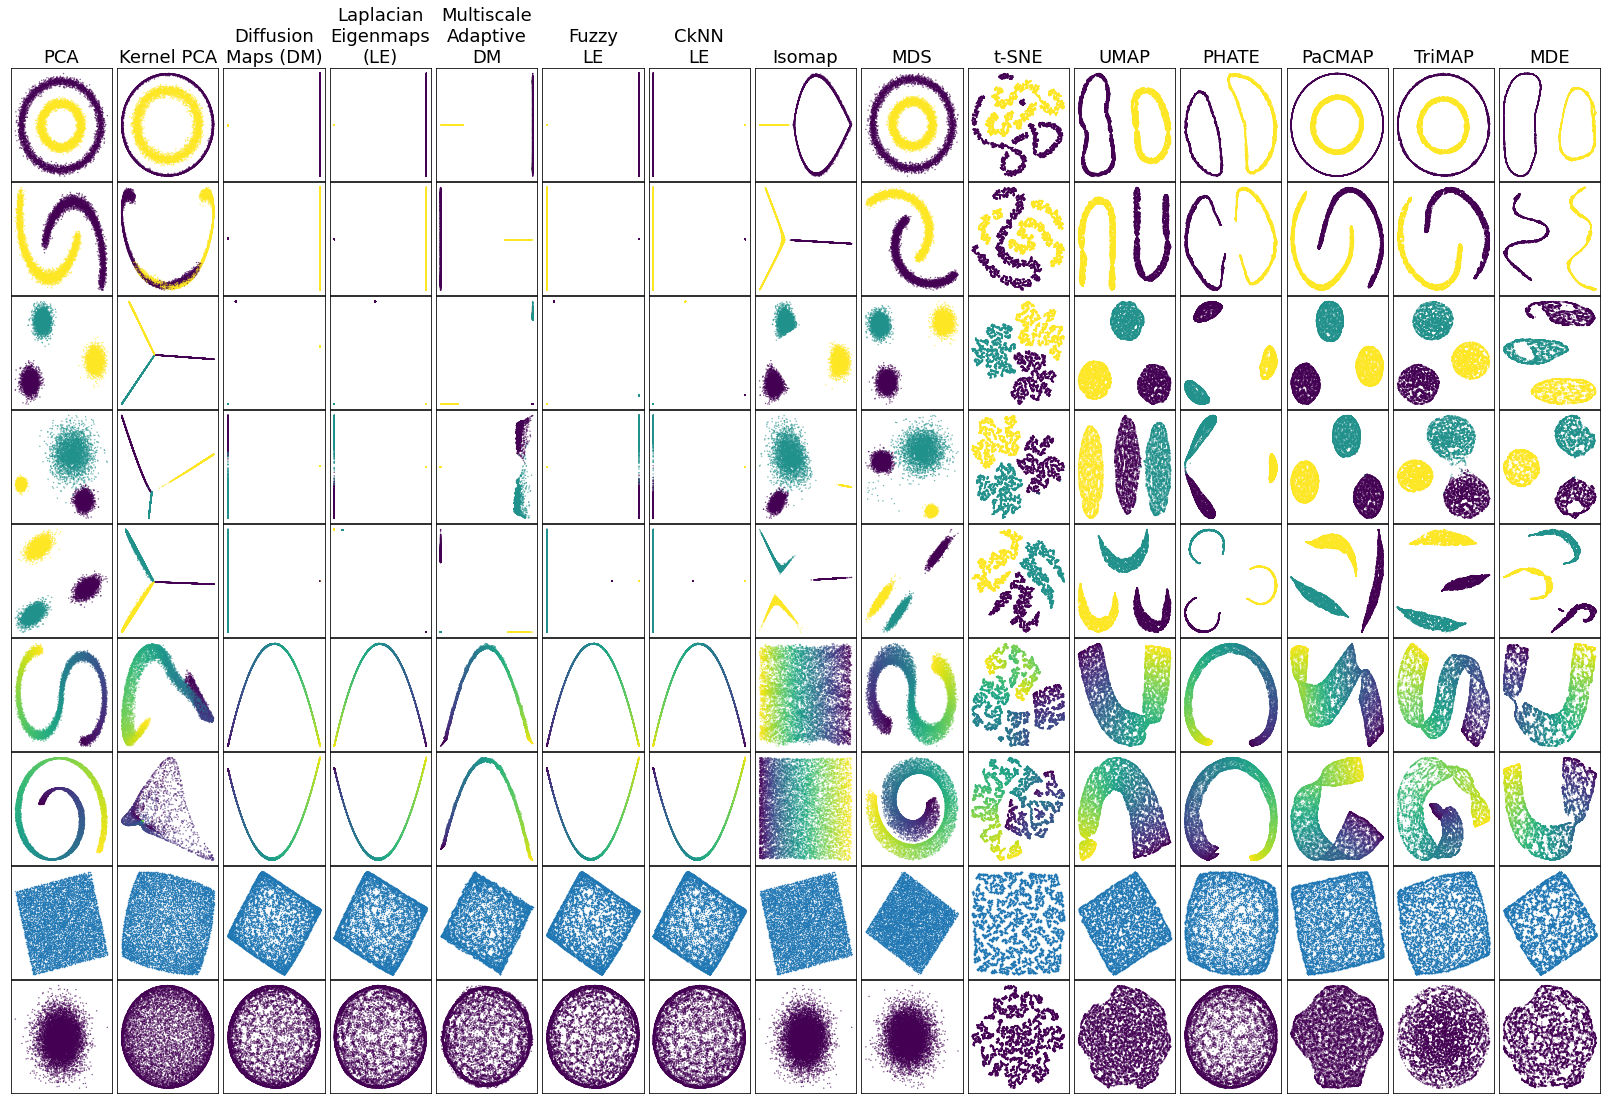

In [68]:
plt.figure(figsize=(9 * 2 + 5, 15))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

for i_dataset, dataset_name in enumerate(toy_datasets):
    # update parameters with dataset-specific values

    data, color = toy_datasets[dataset_name]

    dr_algorithms = (
        ("PCA", PCA),
        ("Kernel PCA", KernelPCA),
        ("Diffusion\nMaps (DM)", DM),
        ("Laplacian\nEigenmaps\n(LE)", Spectral),
        ("Multiscale\nAdaptive\nDM", MSDiffmap),
        ("Fuzzy\nLE", FuzzyLapMap),
        ("CkNN\nLE", CLapMap),
        ("Isomap", Isomap),
        ("MDS", MDS),
        ("t-SNE", tSNE),
        ("UMAP", UMAP),
        ("PHATE", PHATE),
        ("PaCMAP", PaCMAP),
        ("TriMAP", TriMAP),
        ("MDE", MDE),

    )

    for name, algorithm in dr_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            if name in ('PCA', 'Kernel PCA', 'MDS', 't-SNE', 'TriMAP', 'MDE'):
                X_red = algorithm(data)
            else:
                X_red = algorithm(data, n_neighbors=30)

        t1 = time.time()

        plt.subplot(len(toy_datasets), len(dr_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # add black color for outliers (if any)
        #colors = np.append(colors, ["#000000"])

        plt.scatter(X_red[:, 0], X_red[:, 1], s=0.1, c=color)
        

        plt.xticks(())
        plt.yticks(())
        #plt.text(
        #    0.99,
        #    0.01,
        #    ("%.2fs" % (t1 - t0)).lstrip("0"),
        #    transform=plt.gca().transAxes,
        #    size=15,
        #    horizontalalignment="right",
        #)
        plot_num += 1
plt.savefig('/home/davi/Bioinfo/TopOMetry_Paper/Toy_data_visual_benchmark_FINAL.png', dpi=600)
plt.show()

As we can see, different layout methods perform very differently on visually representing this data. Methods that approximate the [Laplace-Beltrami Operator](https://en.wikipedia.org/wiki/Laplace%E2%80%93Beltrami_operator) (LBO), however, yield consistently similar results throghout the examples. This was expected since they converge towards the LBO at the limit of large data.  

Next, let's see how these methods are superior to PCA and its kernelized version to preserve data geometry. For this, we'll need to plot some 3-dimenisonal figures.

/home/davi/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


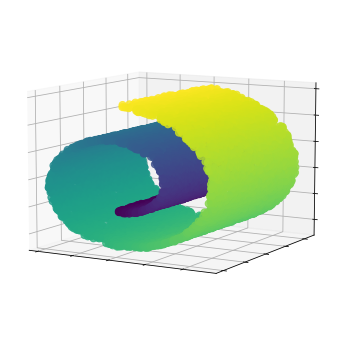

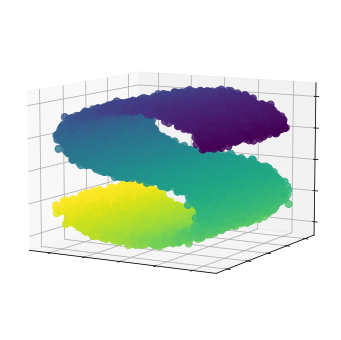

In [69]:
def plot_3d(points, points_color, title, pt_size=50):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=pt_size, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    for line in ax.xaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.yaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.zaxis.get_ticklines():
        line.set_visible(False)
    plt.show()

plot_3d(toy_datasets['swiss_roll'][0], toy_datasets['swiss_roll'][1], title=None)
plot_3d(toy_datasets['s_curve'][0], toy_datasets['s_curve'][1], title=None)

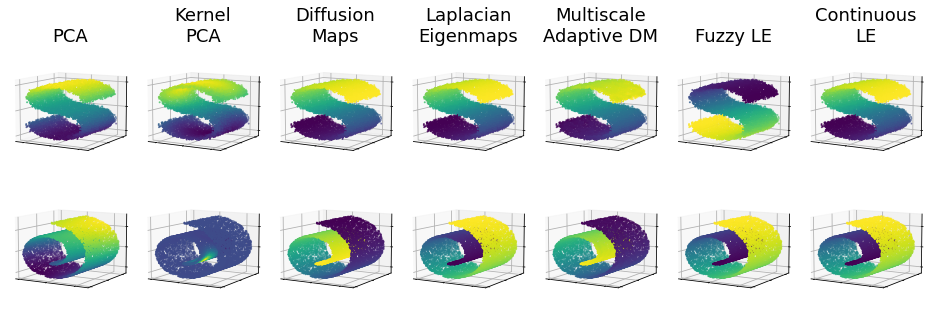

In [70]:
non_linear_datasets = {
     's_curve':s_curve,
     'swiss_roll':swiss_roll,}

fig = plt.figure(figsize=plt.figaspect(.3))
fig.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

for i_dataset, dataset_name in enumerate(non_linear_datasets):
    # update parameters with dataset-specific values

    data, color = non_linear_datasets[dataset_name]
    dr_algorithms = (
        ("PCA", PCA),
        ("Kernel\nPCA", KernelPCA),
        ("Diffusion\nMaps", DM),
        ("Laplacian\nEigenmaps", Spectral),
        ("Multiscale\nAdaptive DM", MSDiffmap),
        ("Fuzzy LE", FuzzyLapMap),
        ("Continuous\nLE", CLapMap),
    )
    for name, algorithm in dr_algorithms:
        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            if name == 'PCA' or name=='Kernel\nPCA':
                X_red = algorithm(data)
            else:
                X_red = algorithm(data, n_neighbors=30)
                
        if i_dataset == 0:
            ax = fig.add_subplot(len(non_linear_datasets), len(dr_algorithms), plot_num, projection='3d')
            ax.set_title(name, size=18)
        else:
            ax = fig.add_subplot(len(non_linear_datasets), len(dr_algorithms), plot_num, projection='3d')

        ax.scatter(data[:, 0], data[:, 1], data[:,2], s=1, c=X_red[:, 0])
        ax.view_init(azim=-60, elev=9)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.zaxis.set_ticklabels([])

        for line in ax.xaxis.get_ticklines():
            line.set_visible(False)
        for line in ax.yaxis.get_ticklines():
            line.set_visible(False)
        for line in ax.zaxis.get_ticklines():
            line.set_visible(False)
        plot_num += 1
        
plt.savefig('/home/davi/Bioinfo/TopOMetry_Paper/Toy_data_3D_non_linear_visual_benchmark.png', dpi=600)
plt.show()

Now let's visualize the same stuff but in 2D

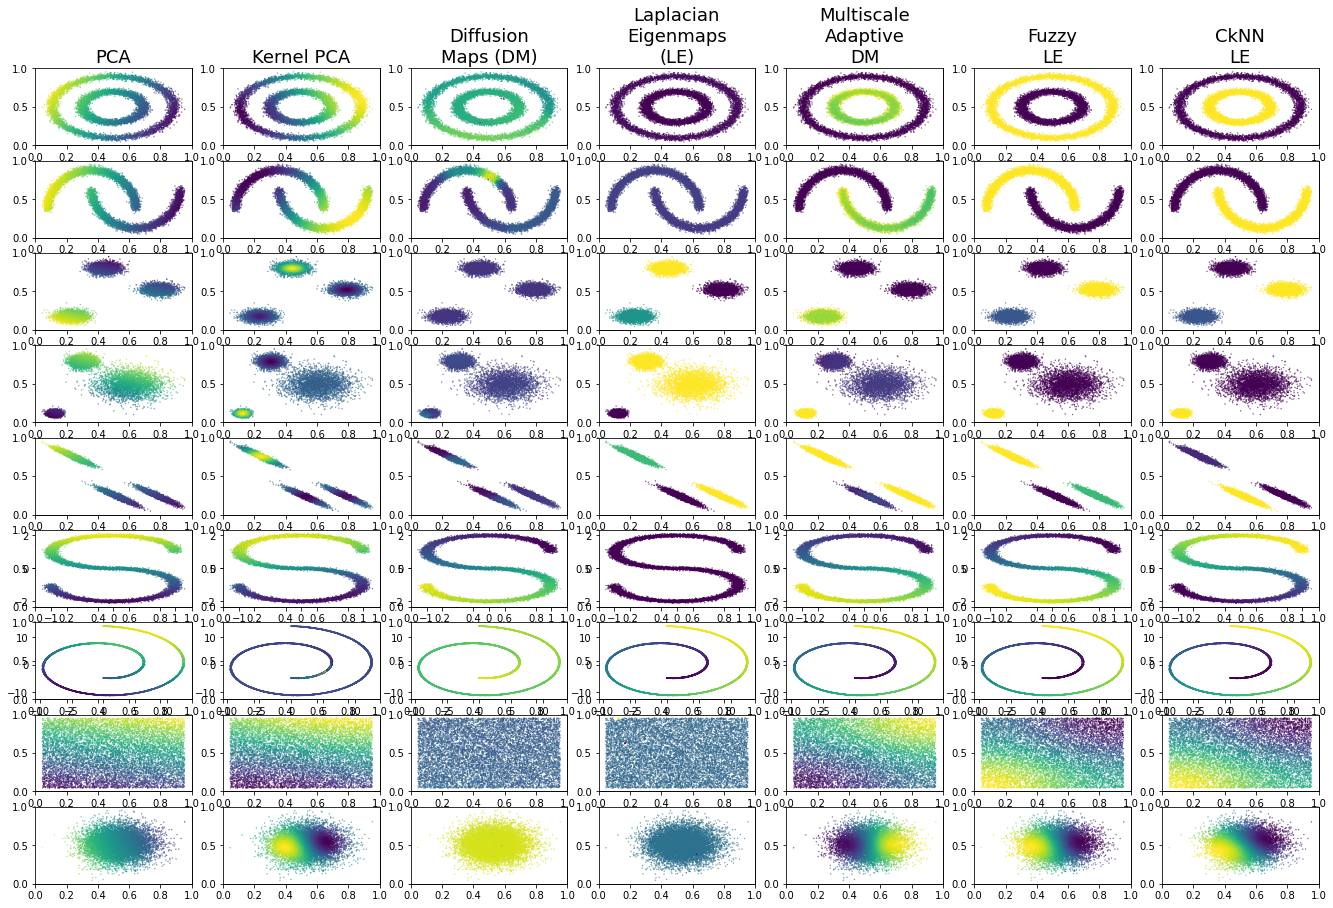

In [73]:
fig = plt.figure(figsize=(9 * 2 + 5, 15))

plot_num = 1

for i_dataset, dataset_name in enumerate(toy_datasets):
    # update parameters with dataset-specific values

    data, color = toy_datasets[dataset_name]

    dr_algorithms = (
        ("PCA", PCA),
        ("Kernel PCA", KernelPCA),
        ("Diffusion\nMaps (DM)", DM),
        ("Laplacian\nEigenmaps\n(LE)", Spectral),
        ("Multiscale\nAdaptive\nDM", MSDiffmap),
        ("Fuzzy\nLE", FuzzyLapMap),
        ("CkNN\nLE", CLapMap)
    )

    for name, algorithm in dr_algorithms:
        # DM has an eigenvalue convergence error for exact solution in this case
        # so we'll increase it's tolerance
        # catch warnings related to kneighbors_graph
        if name == "Diffusion\nMaps (DM)":
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                X_red = algorithm(data, tol=1e-4)
        else:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                X_red = algorithm(data)
        if i_dataset == 0:
            ax = fig.add_subplot(len(toy_datasets), len(dr_algorithms), plot_num)
            ax.set_title(name, size=18)
        else:
            ax = fig.add_subplot(len(toy_datasets), len(dr_algorithms), plot_num)
            
        if (dataset_name == 's_curve') or (dataset_name == 'swiss_roll'):
            ax = fig.add_subplot(len(toy_datasets), len(dr_algorithms), plot_num)
            ax.scatter(data[:, 0], data[:, 2], s=0.1, c=X_red[:, 0])
        else:
            ax = fig.add_subplot(len(toy_datasets), len(dr_algorithms), plot_num)
            ax.scatter(data[:, 0], data[:, 1], s=0.1, c=X_red[:, 0])
            plt.xticks(())
            plt.yticks(())

        plot_num += 1

plt.show()

## Test visualization methods with artificial trees

### Define visualization approaches

Now we'll define functions that correspond to the more frequent strategies used to approach high-dimensional data visualization. In loose terms, current strategies can be summarized as follows:

* Direct embedding: methods that learn an n-dimensional orthogonal basis. Two or three dimensions can be used for visualization to the human eye. These methods include PCA, Diffusion Maps (DM), Laplacian Eigenmaps (LE) and matrix factorization algorithms.
* Direct layout: directly inputting data to a graph layout method, such as UMAP, t-SNE, PaCMAP, TriMAP or MDE. My criterium for putting a method in this category is being basic on minimizing some loss function between the high-dimensional neighborhood graph learned from data and the 2- or 3-D desired visualization.
* Denoised layout: first embed data to a n-dimensional orthogonal basis (usually with PCA), then use this new basis to train a layout method to learn 2- or 3-D visualizations. This is by far the most frequently used strategy across a variety of domains, as it increases both the computational efficiency and the visualization performance of layout algorithms. This strategy is also currently hold as a gold-standard in single-cell data analysis despite solid justification, as the use of PCA for embedding/denoising has never been benchmarked with non-linear methods. This category includes the classic t-SNE on PCA and UMAP on PCA visualizations. Is also includes PHATE, which performs PCA under the hood before neighborhood graph construction.

For the purposes of this demonstration, we'll compare the layout methods tSNE, UMAP, Isomap, MDE and PaCMAP on a denoised basis. As bases, we'll compare PCA, DM, LE, and the diffusion and fuzzy graphs options in TopOMetry. Lastly, we'll also compare the layout using diffusion- and fuzzy-weighted MAP (a lighter non-uniform version included in TopOMetry) to the default UMAP layouts on orthogonal bases.

In [25]:
# Define methods to be tested

#
# UMAP on PCA
def UMAP_on_PCA(data, n_pcs=3, **kwargs):
    pcs = PCA(data, n_pcs=n_pcs)
    umap_on_pca = UMAP(pcs, *kwargs)
    return umap_on_pca

In [26]:
test = UMAP_on_PCA(toy_datasets['swiss_roll'][0])

In [ ]:

# First, general models (including some of those used in TopOMetry)

from sklearn import decomposition, manifold

# Spectral (Laplacian Eigenmaps)
def Spectral(data, n_components=2, n_jobs=-1, n_neighbors=5):
    return manifold.SpectralEmbedding(n_components=n_components, n_jobs=n_jobs,
                                      n_neighbors=n_neighbors).fit_transform(data)

# UMAP on PCA
def UMAP_on_PCA(data, n_pcs=100, **kwargs):
    pcs = PCA(data, n_pcs=n_pcs)
    umap_on_pca = UMAP(pcs, **kwargs)
    return umap_on_pca

# UMAP - already defined

# Isomap on PCA
def Isomap(data, n_pcs=100, n_components=2, n_neighbors=5, metric='euclidean', n_jobs=-1):
    pcs = PCA(data, n_pcs=n_pcs)
    return manifold.Isomap(n_components=n_components, n_neighbors=n_neighbors,
                           metric=metric, n_jobs=n_jobs).fit_transform(pcs)

# PHATE - already defined

# PaCMAP - already defined

# PaCMAP on PCA

# TriMAP

# TriMAP on PCA
def TriMAP_on_PCA(data, n_components=2, n_iters=400, apply_pca=True):
    import trimap
    return trimap.TRIMAP(n_dims=n_components, n_iters=n_iters, apply_pca=apply_pca, verbose=False).fit_transform(data)

# MDE

# Next, TopOMetry embedding models:

def db_PaCMAP(data):
    tg.backend='hnswlib'
    tg.base_metric = 'euclidean'
    tg.base_knn = n_neighbors
    tg.n_eigs = n_components
    tg.basis='diffusion'
    tg.kernel_use='simple'
    tg.norm = True
    tg.run_layouts()


def MSDiffmap(data, n_neighbors=30, n_components=3, tol=0):
    tg = tp.TopOGraph(verbosity=0, n_jobs=-1, tol=tol)
    tg.backend='hnswlib'
    tg.base_metric = 'euclidean'
    tg.base_knn = n_neighbors
    tg.n_eigs = n_components
    tg.basis='diffusion'
    tg.kernel_use='simple'
    tg.norm = True
    tg.fit(data)
    return tg.MSDiffMap


def FuzzyLapMap(data, n_neighbors=30, n_components=3, tol=0):
    tg = tp.TopOGraph(verbosity=0, n_jobs=-1, tol=tol)
    tg.backend='hnswlib'
    tg.base_metric = 'euclidean'
    tg.base_knn = n_neighbors
    tg.n_eigs = n_components
    tg.basis='fuzzy'
    tg.fit(data)
    return tg.FuzzyLapMap


def CLapMap(data, n_neighbors=30, n_components=3, tol=0):
    tg = tp.TopOGraph(verbosity=0, n_jobs=-1, tol=tol)
    tg.base_metric = 'euclidean'
    tg.backend='hnswlib'
    tg.base_knn = n_neighbors
    tg.n_eigs = n_components
    tg.basis='continuous'
    tg.fit(data)
    return tg.CLapMap

Now let's make some N-dimensional trees with increasing complexity and dimensionality to see how different algorithms perform on them 

In [1]:
##########
# Artificial trees
##########

def gen_dla(
    n_dim=100, n_branch=20, branch_length=100, rand_multiplier=1, seed=42, sigma=5
):
    np.random.seed(seed)
    M = np.cumsum(-1 + rand_multiplier * np.random.rand(branch_length, n_dim), 0)
    for i in range(n_branch - 1):
        ind = np.random.randint(branch_length)
        new_branch = np.cumsum(
            -1 + rand_multiplier * np.random.rand(branch_length, n_dim), 0
        )
        M = np.concatenate([M, new_branch + M[ind, :]])

    noise = np.random.normal(0, sigma, M.shape)
    M = M + noise

    # returns the group labels for each point to make it easier to visualize
    # embeddings
    C = np.array([i // branch_length for i in range(n_branch * branch_length)])

    return M, C

tree_low_branches_low_dim = gen_dla(branch_length=300, n_branch=10, n_dim=200)
tree_mid_branches_low_dim = gen_dla(branch_length=300, n_branch=50, n_dim=200)
tree_high_branches_low_dim = gen_dla(branch_length=300, n_branch=150, n_dim=200)
#tree_low_branches_mid_dim = gen_dla(branch_length=300, n_branch=10, n_dim=800)
#tree_mid_branches_mid_dim = gen_dla(branch_length=300, n_branch=50, n_dim=800)
#tree_high_branches_mid_dim = gen_dla(branch_length=300, n_branch=150, n_dim=800)
#tree_low_branches_high_dim = gen_dla(branch_length=300, n_branch=10, n_dim=3200)
#tree_mid_branches_high_dim = gen_dla(branch_length=300, n_branch=50, n_dim=3200)
tree_high_branches_high_dim = gen_dla(branch_length=300, n_branch=150, n_dim=3200)

NameError: name 'np' is not defined

In [15]:
np.shape(tree_low_branches_low_dim[0])

(3000, 200)

In [18]:
trees = {
     'low n. branches / low dim.':tree_low_branches_low_dim,
     'mid n. branches / low dim.':tree_mid_branches_low_dim,
     'high n. branches / low dim.':tree_high_branches_low_dim}

KeyboardInterrupt: 

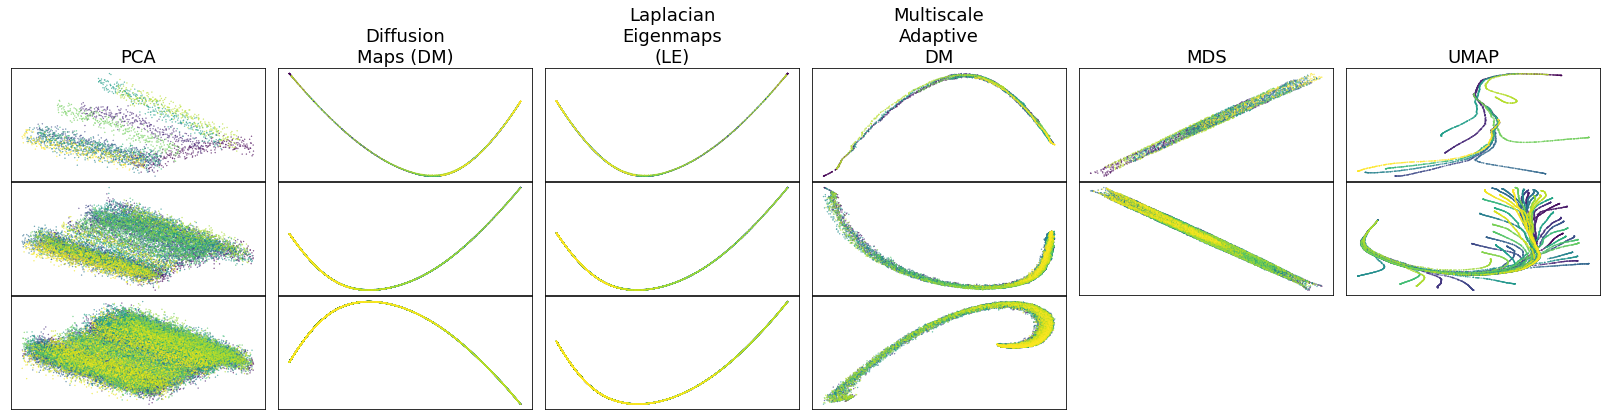

In [19]:
plt.figure(figsize=(9 * 2 + 5, 15))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

for i_dataset, dataset_name in enumerate(trees):
    # update parameters with dataset-specific values

    data, color = trees[dataset_name]

    dr_algorithms = (
        ("PCA", PCA),
        #("Kernel PCA", KernelPCA),
        ("Diffusion\nMaps (DM)", DM),
        ("Laplacian\nEigenmaps\n(LE)", Spectral),
        ("Multiscale\nAdaptive\nDM", MSDiffmap),
        #("Fuzzy\nLE", FuzzyLapMap),
        #("CkNN\nLE", CLapMap),
        #("Isomap", Isomap),
        #("MDS", MDS),
        #("t-SNE", tSNE),
        #("UMAP", UMAP),
        #("PHATE", PHATE),
        #("PaCMAP", PaCMAP),
        #("TriMAP", TriMAP),
        #("MDE", MDE),

    )

    for name, algorithm in dr_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            if name in ('PCA', 'Kernel PCA', 'MDS', 't-SNE', 'TriMAP', 'MDE'):
                X_red = algorithm(data)
            else:
                X_red = algorithm(data, n_neighbors=30)

        t1 = time.time()

        plt.subplot(len(toy_datasets), len(dr_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # add black color for outliers (if any)
        #colors = np.append(colors, ["#000000"])

        plt.scatter(X_red[:, 0], X_red[:, 1], s=0.1, c=color)
        

        plt.xticks(())
        plt.yticks(())
        #plt.text(
        #    0.99,
        #    0.01,
        #    ("%.2fs" % (t1 - t0)).lstrip("0"),
        #    transform=plt.gca().transAxes,
        #    size=15,
        #    horizontalalignment="right",
        #)
        plot_num += 1
plt.savefig('/home/davi/Bioinfo/TopOMetry_Paper/Toy_data/trees_test.png', dpi=600)
plt.show()